In [48]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os


In [49]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001', 'engine_LPD001_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


119
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\engine_LPD001_result


In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [51]:


# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y = data['Engine Condition']

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング

# データセットを分割（train, test）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# NumPy配列をPyTorchのTensorに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # 分類用ラベル
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# TensorDatasetを作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaderを作成（バッチ処理用）
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
for batch_X, batch_y in train_dataloader:
    print("Batch X Shape:", batch_X.shape)
    print("Batch y Shape:", batch_y.shape)
    break


Batch X Shape: torch.Size([32, 6])
Batch y Shape: torch.Size([32])


In [52]:
class Encoder(nn.Module):#LPD
    def __init__(self, input_dim, leverage):
        super(Encoder, self).__init__()
        self.leverage = leverage

        self.B = nn.Parameter(torch.randn(int(input_dim/leverage), input_dim) * (1/np.sqrt(input_dim)))#.to(device)
        self.B.requires_grad = False

    
    def forward(self, x):
        x = torch.matmul(self.B, x.T).T
        x = torch.abs(x)**2
        return x

In [53]:
class PreBlock(nn.Module):

    def __init__(self, in_dim, out_dim, use_ln):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        self.relu = nn.LeakyReLU(inplace=True)
        self.use_ln = use_ln
        if use_ln:
            self.ln = nn.LayerNorm(out_dim)

    def forward(self, x):
        x = self.fc(x)       # (B, out_dim)
        if self.use_ln:
            x = self.ln(x)
        x = self.relu(x)
        return x

In [54]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out):
        super(Decoder, self).__init__()

        #self.pre = nn.Sequential(nn.Linear(num_in, num_in),nn.LayerNorm(num_in),nn.ReLU())
        self.decoder_fc1 = nn.Linear(num_in, int((num_in + num_out) / 2))
        self.a1 = nn.Tanh()
        self.decoder_fc2 = nn.Linear(int((num_in + num_out) / 2), num_out)
        #self.a2 = nn.ReLU()

    def forward(self, x):
        #x = self.pre(x)
        x = self.decoder_fc1(x)
        x = self.a1(x)
        x = self.decoder_fc2(x)
        #x = self.a2(x)
        return x

In [55]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, leverage):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(input_dim, leverage)
        self.decoder = Decoder(int(input_dim / leverage), input_dim)

    def forward(self, x):
        x = self.encoder(x)
        x_reconstructed = self.decoder(x)
        return x_reconstructed

In [56]:


def TableCreater(batch_X, scaler, columns):

    # 有効数字の定義
    significant_digits = {
        'Engine rpm': 5,
        'Lub oil pressure': 8,
        'Fuel pressure': 8,
        'Coolant pressure': 8,
        'lub oil temp': 7,
        'Coolant temp': 7
    }

    # 有効数字を適用する関数
    def apply_significant_digits(value, digits):
        if value == 0:
            return 0
        else:
            return round(value, digits - int(np.floor(np.log10(abs(value)))) - 1)

    # スケールを元に戻す
    X_original = batch_X.numpy() * scaler.scale_ + scaler.mean_
    restored_df = pd.DataFrame(X_original, columns=columns)

    # 各特徴量に有効数字を適用
    for column, digits in significant_digits.items():
        if column in restored_df.columns:
            restored_df[column] = restored_df[column].apply(apply_significant_digits, args=(digits,))

    return restored_df.head(5).to_csv(sep='\t', index=False) # 最初の5行を返す



In [57]:
def plot_histograms(all_X, scaler, columns):

    # バッチデータを1つの配列に結合
    all_X_combined = np.vstack(all_X)

    # 標準化を元に戻す
    all_original_X = all_X_combined * scaler.scale_ + scaler.mean_

    # ヒストグラムを特徴量ごとに作成
    num_features = len(columns)  # 特徴量の数
    rows = (num_features + 2) // 3  # 3列2行で表示するための行数計算
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    # 各特徴量のヒストグラムをプロット
    for i, column in enumerate(columns):  # columns は特徴量名を使用
        row, col = divmod(i, 3)
        ax = axes[row, col]
        ax.hist(all_original_X[:, i], bins=20, edgecolor='k', alpha=0.7)
        ax.set_title(f'Histogram of {column}',fontsize=18)
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.5)

    # 空白のプロットを削除
    for j in range(num_features, rows * 3):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

In [58]:
for batch_X, batch_y in test_dataloader:
    processed_df = TableCreater(batch_X, scaler, data.columns.drop('Engine Condition'))
    break

# 結果の表示
print(processed_df)

Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
682.0	2.3916559	4.6171958	2.8489821	76.27242	69.88461
605.0	5.4668769	6.4243607	5.7275201	73.22268	74.90731
658.0	3.4342322	3.6808963	1.6787082	88.08992	78.70481
749.0	2.0946565	7.120927	1.6396704	77.66163	82.3867
676.0	3.538228	5.9564724	3.2253363	75.22635	67.15322



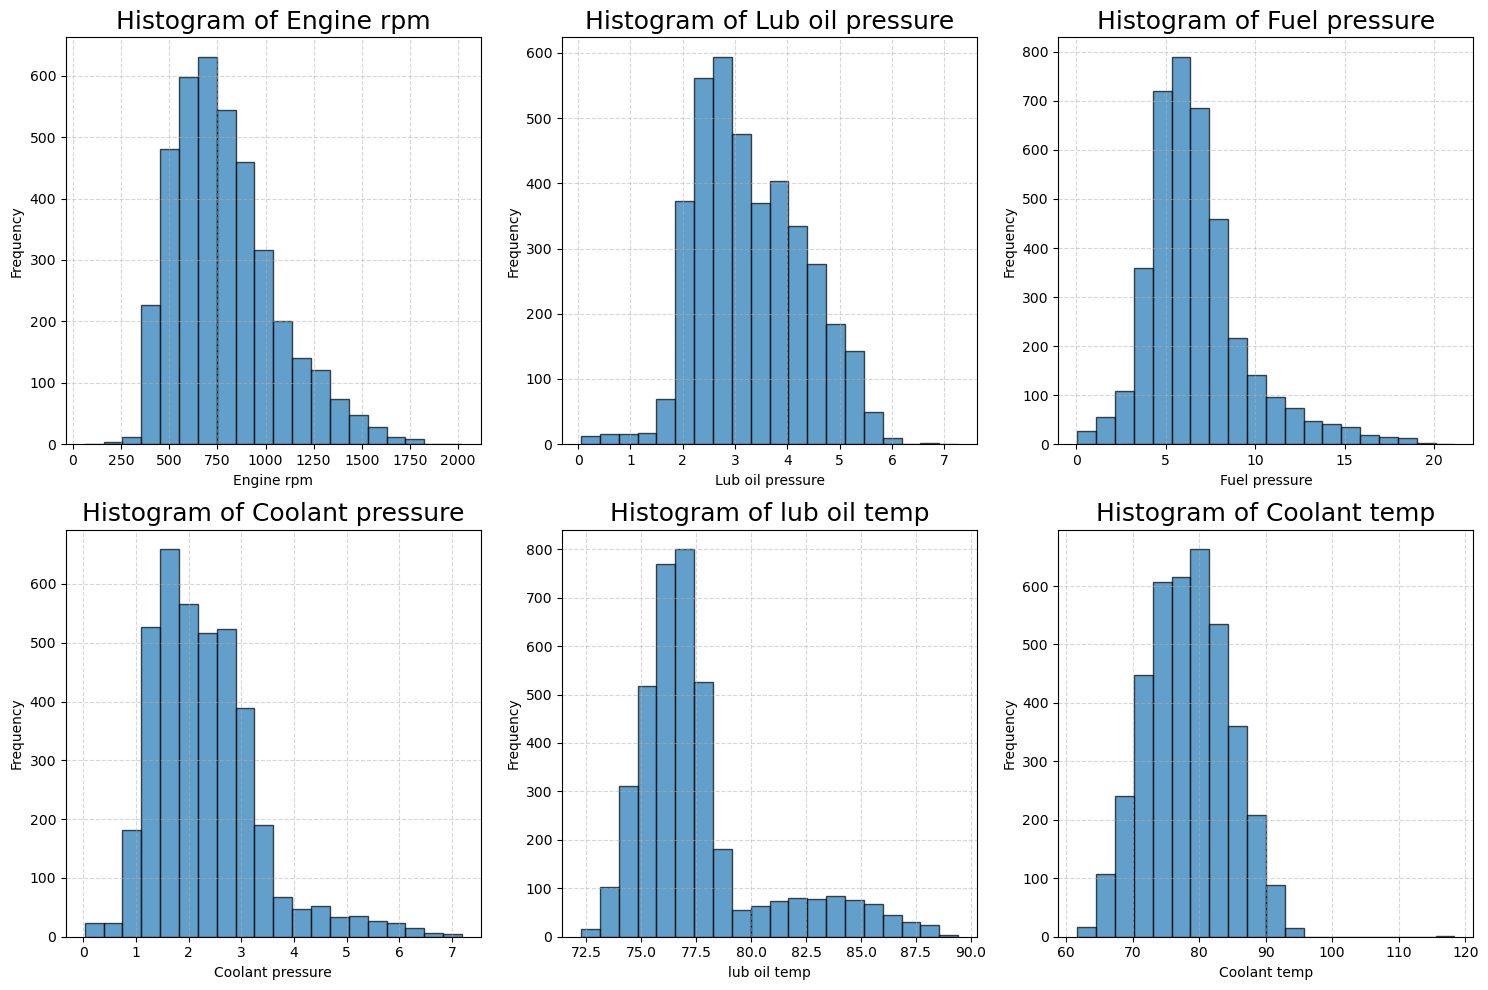

In [59]:
all_X = []
for batch_X, _ in test_dataloader:
    all_X.append(batch_X.numpy())

plot_histograms(all_X, scaler, data.columns.drop('Engine Condition'))

1/5th Time Epoch: 20/20

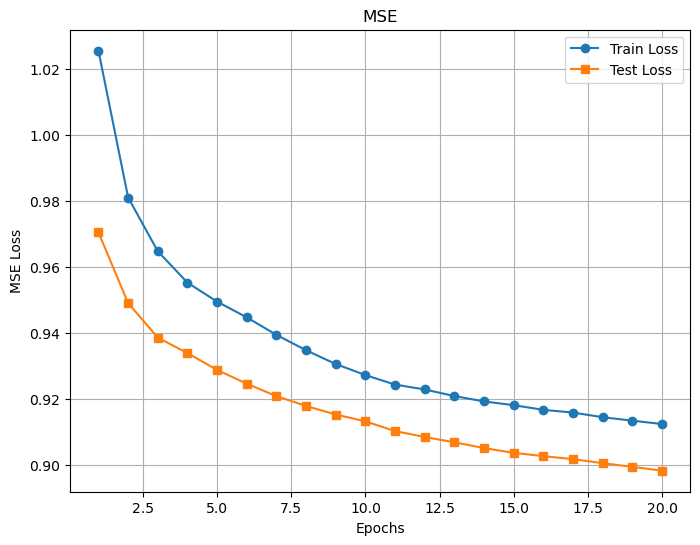

MSE 0.8983005556633802
Time 21.198832511901855
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
746.76	3.3406027	5.9832684	2.4246014	77.1219	78.23925
1034.3	3.5228295	7.7934082	3.9326399	78.10839	79.58716
721.11	3.2313014	6.1755861	2.1080228	77.51631	78.4082
714.28	3.3137033	6.000941	2.1831721	77.3504	78.22814
774.84	3.3490592	5.8366067	2.8418282	77.62927	78.78604



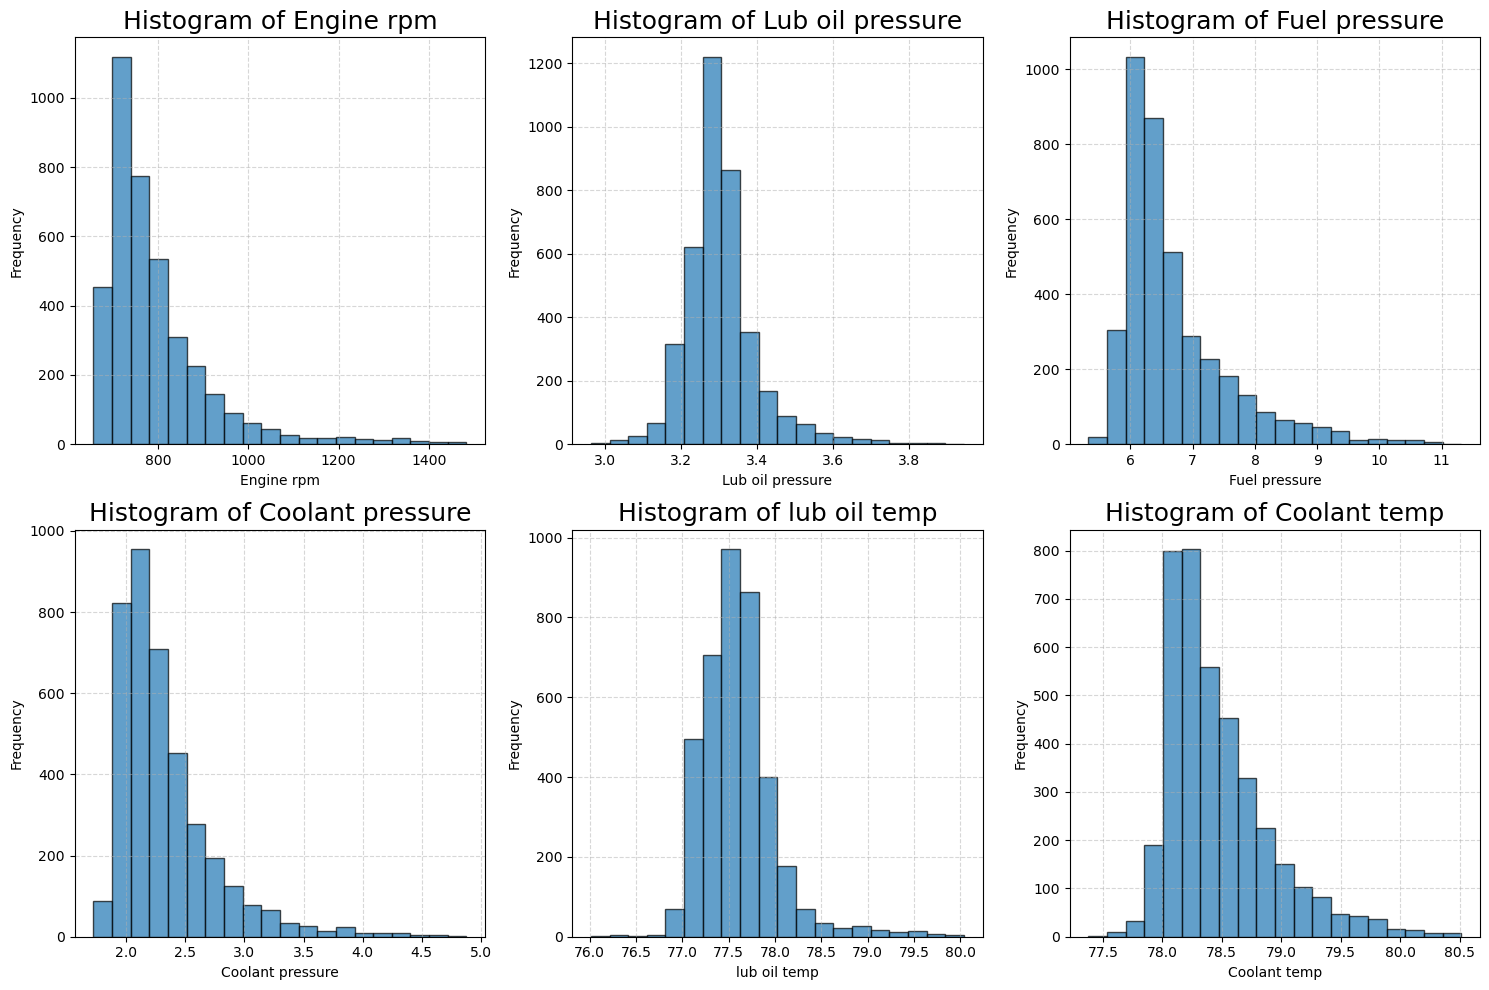

2/5th Time Epoch: 20/20

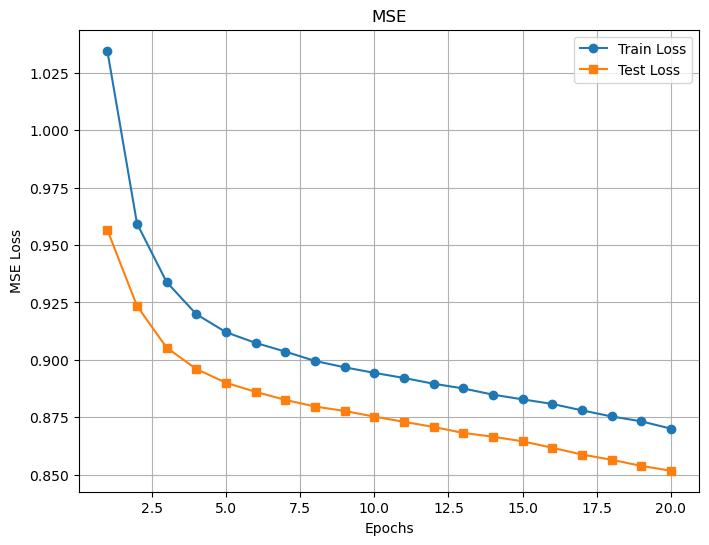

MSE 0.8516488647073265
Time 22.20199990272522
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
767.63	3.1763597	6.1172394	2.2233074	76.84018	78.25232
749.23	3.4579582	7.8374828	3.8882532	79.40758	79.09278
754.6	3.1515871	5.6293656	3.0026308	84.90211	79.44036
764.95	3.1827458	6.2521387	2.0667669	76.49792	78.62007
743.74	3.2056089	6.4719842	1.9929345	76.91597	78.22207



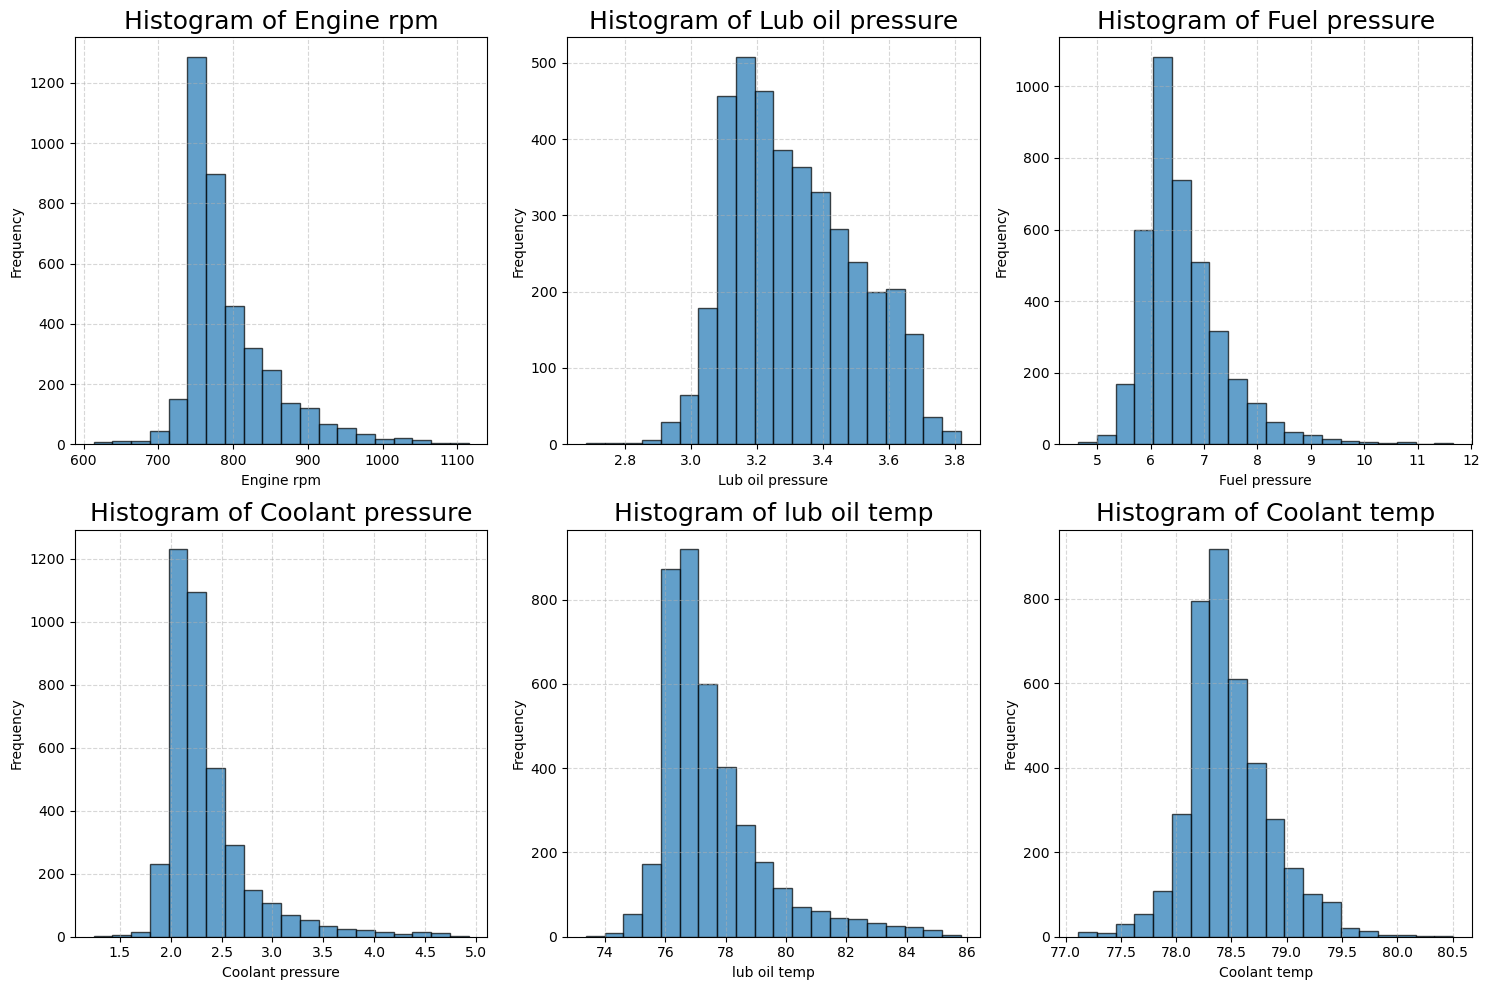

3/5th Time Epoch: 20/20

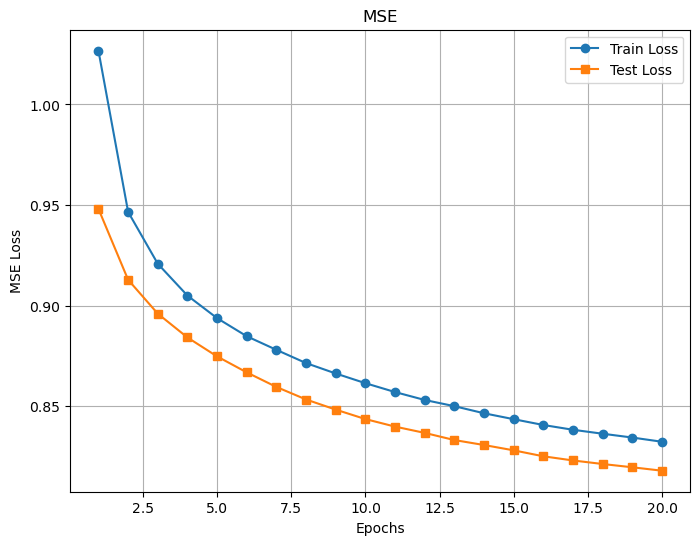

MSE 0.817949695800378
Time 23.220325231552124
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
712.23	3.2973815	6.5124263	2.2045425	76.81188	76.83673
848.39	3.180873	6.9095214	4.6952997	79.00152	77.91829
721.21	3.4227849	7.078782	2.8209938	84.02819	81.9967
652.79	3.2648032	5.7133463	2.037218	76.59324	79.46599
697.39	3.2671286	6.5753508	2.4681755	78.53539	78.30717



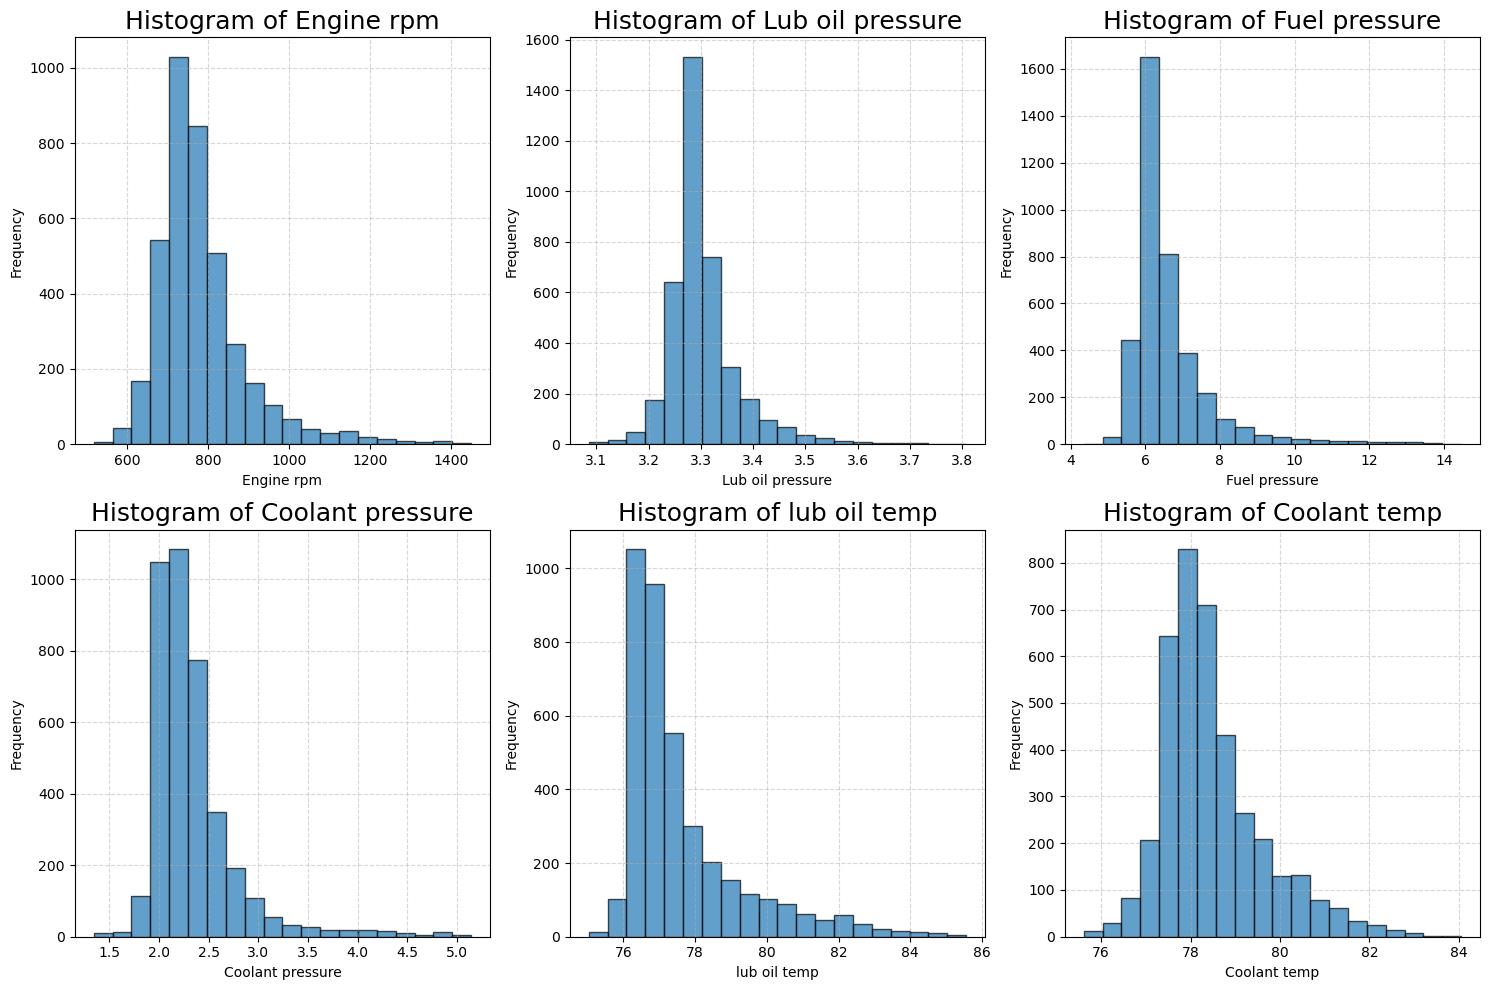

4/5th Time Epoch: 20/20

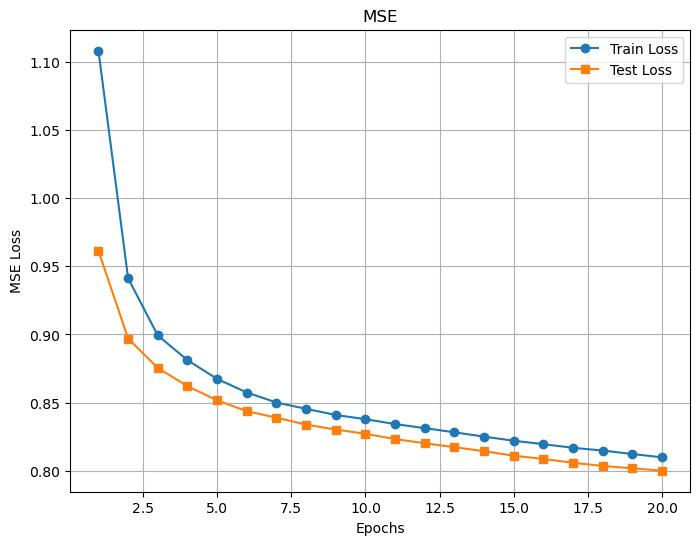

MSE 0.7999073363901154
Time 23.50822162628174
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
733.71	3.2988799	6.5004687	2.0866723	76.79936	77.92594
944.01	3.2973865	7.5124945	3.2809093	77.20791	79.85684
802.69	3.13225	6.6619253	2.3687655	87.20094	81.78952
742.52	3.4170715	6.6098151	2.2336866	76.47404	78.52616
738.98	3.312639	6.4799964	2.2563038	76.89057	78.78056



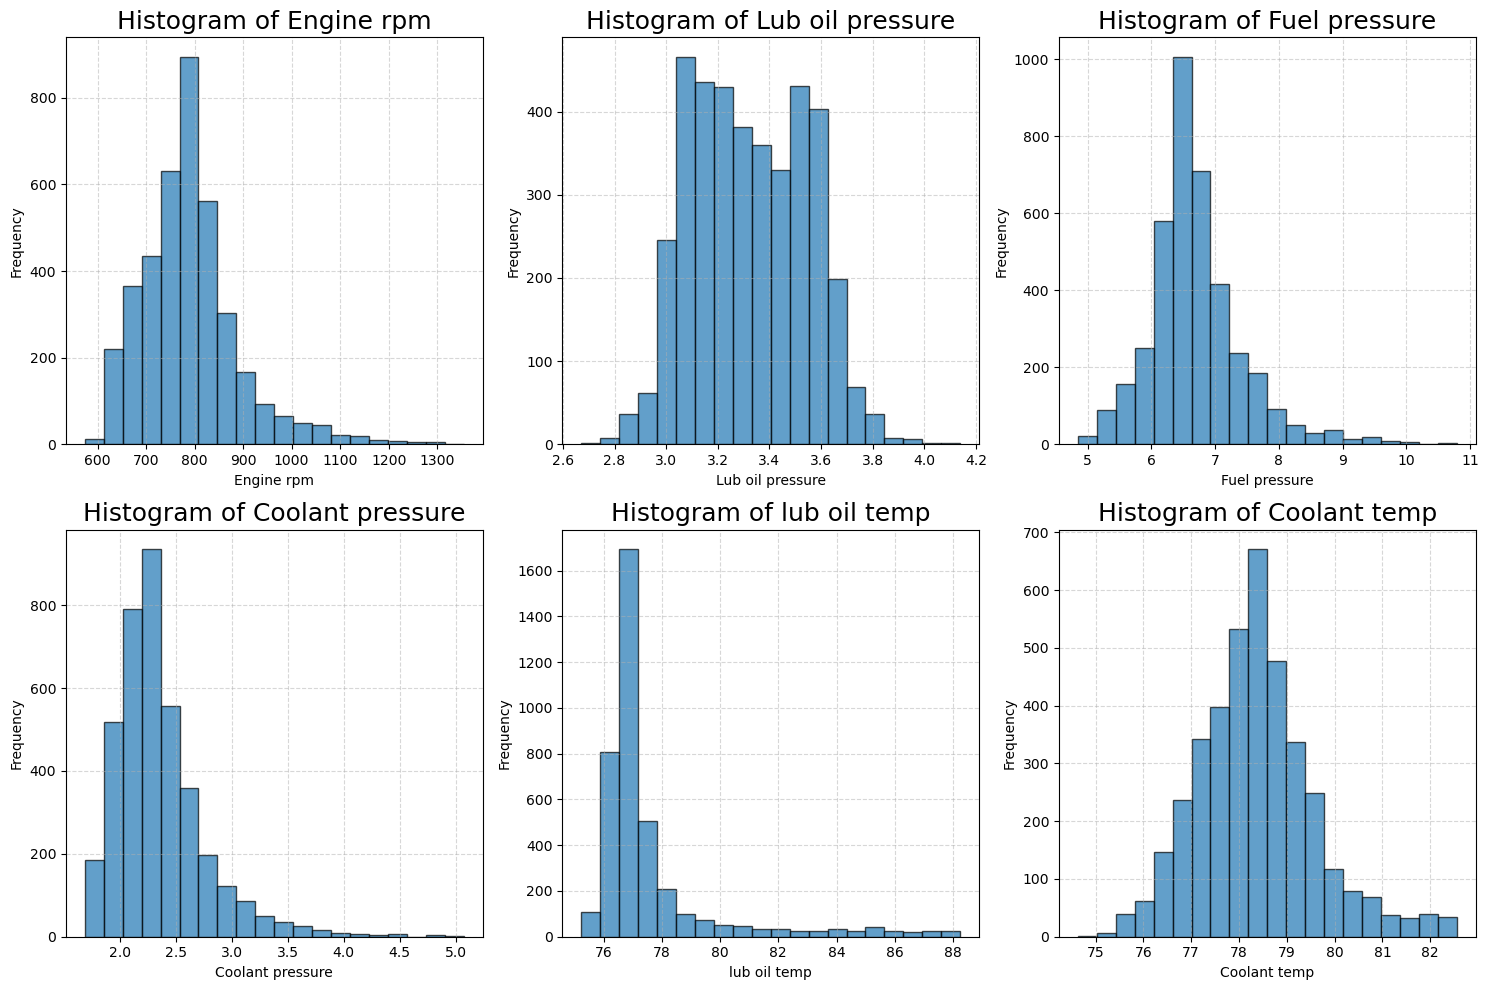

5/5th Time Epoch: 20/20

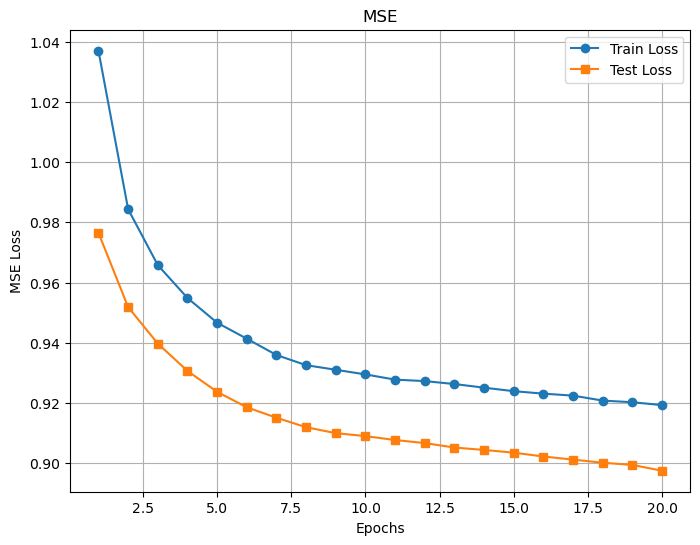

MSE 0.897448873132225
Time 22.223023653030396
Engine rpm	Lub oil pressure	Fuel pressure	Coolant pressure	lub oil temp	Coolant temp
756.47	3.2079532	6.800067	2.4004956	77.92091	77.77487
835.35	3.6977277	7.5726649	4.2007602	78.16185	79.01476
787.5	3.2874612	6.7138496	2.5209758	82.26309	80.06989
770.05	3.2783569	6.4561278	2.1818603	76.7144	77.99936
775.0	3.2311367	7.0593786	2.4184348	79.64951	78.26747



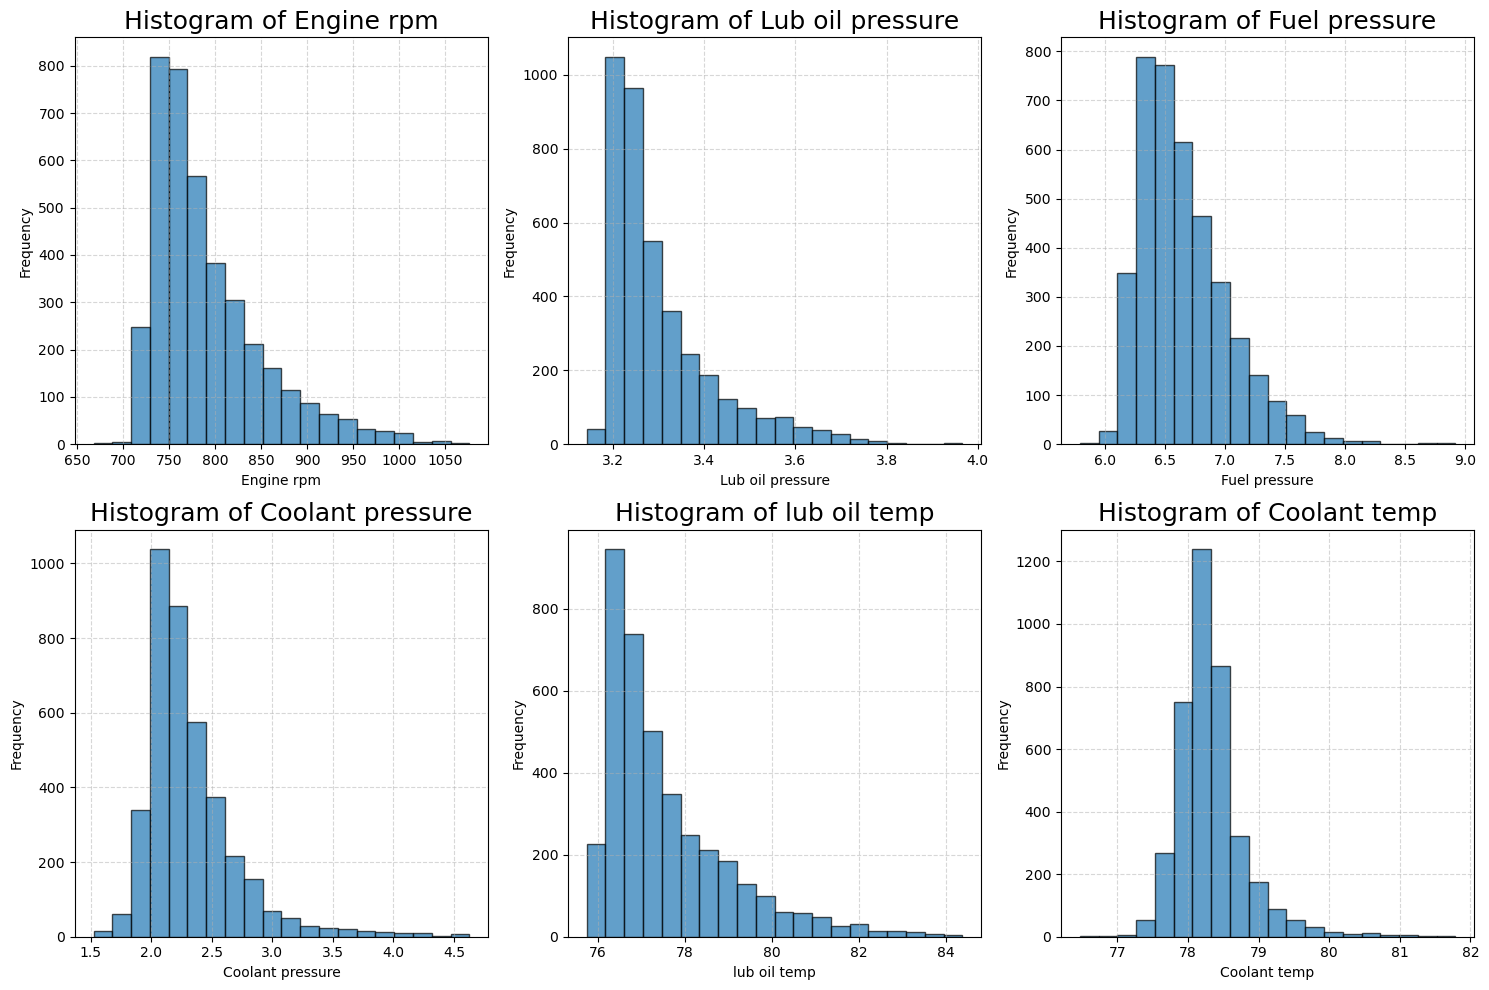

In [60]:
input_dim = X_train.shape[1]
leverage = 1  # 圧縮倍率
max_epochs = 20
lr = 0.0005 #学習率

num_try = 5 #

All_last_loss = []
All_loss_test = []
All_pro_time = []

for num_times in range(num_try): 
    model = AutoEncoder(input_dim, leverage).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss_train = 0
        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        start_time1 = time.time()
        for batch_X, _ in train_dataloader:
            batch_X = batch_X.to(device)

            reconstructed = model(batch_X)
            loss = criterion(reconstructed, batch_X)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

        epoch_loss_train /= len(train_dataloader)
        loss_train_.append(epoch_loss_train)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        # テスト損失計算
        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():
            for batch_X, _ in test_dataloader:
                batch_X = batch_X.to(device)
                reconstructed = model(batch_X)
                loss = criterion(reconstructed, batch_X)
                epoch_loss_test += loss.item()

        epoch_loss_test /= len(test_dataloader)
        loss_test_.append(epoch_loss_test)

        if epoch == max_epochs-1:
            All_loss_test.append(loss_test_)
            All_pro_time.append(sum(pro_time_)) 
            Last_loss_test = loss_test_[-1]
            All_last_loss.append(Last_loss_test)

    # 収束グラフ
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, max_epochs+1), loss_train_, label='Train Loss', marker='o')
    plt.plot(range(1, max_epochs+1), loss_test_, label='Test Loss', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('MSE',epoch_loss_test)
    print('Time',sum(pro_time_))

    all_test_X = []
    with torch.no_grad():  # 勾配計算を無効化
        for batch_X, _ in test_dataloader:
            batch_X = batch_X.to(device)
            reconstructed = model(batch_X).cpu().detach()  # モデルに通して復元
            all_test_X.append(reconstructed.numpy())

    with torch.no_grad():  # 勾配計算を無効化
        for batch_X, _ in test_dataloader:
            batch_X = batch_X.to(device)
            reconstructed = model(batch_X).cpu().detach()  # モデルに通して復元
            processed_df = TableCreater(reconstructed, scaler, data.columns.drop('Engine Condition'))
            print(processed_df)
            break

    plot_histograms(all_test_X, scaler, data.columns.drop('Engine Condition'))

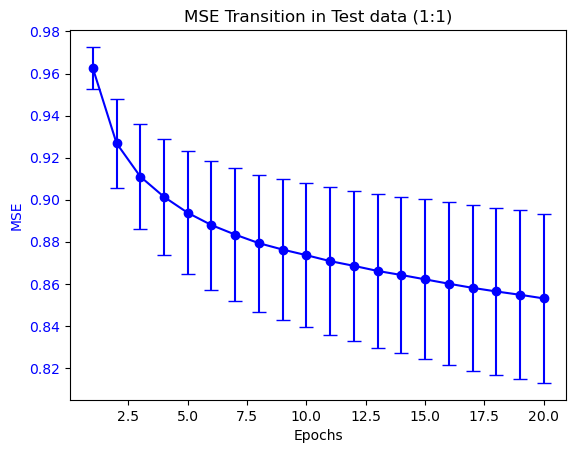

In [61]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('MSE Transition in Test data (1:%d)' % leverage)
file_name = '%d_MSE_errorbar.png'%(int(formatted_date))
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')

plt.show()

In [62]:

MSE_mean = np.mean(All_last_loss)
MSE_best = np.min(All_last_loss)
MSE_bestID = np.argmin(All_last_loss)+1
MSE_worst = np.max(All_last_loss)
MSE_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["MSE"],
    "Average": [MSE_mean],
    "Best ID": [MSE_bestID],
    "Best": [MSE_best],
    "Worst ID": [MSE_worstID],
    "Worst": [MSE_worst],
}

df = pd.DataFrame(data)

print(df)


         Average  Best ID      Best  Worst ID     Worst
0  MSE  0.853051        4  0.799907         1  0.898301


In [63]:
pro_time_mean = sum(All_pro_time)/len(All_pro_time)
data2 = {
    "Index": list(range(1, len(All_pro_time) + 1)),  # インデックス（1から開始）
    "Processing Time": All_pro_time                # 各処理時間
}

df2 = pd.DataFrame(data2)
df2.loc[""] = ["Average", pro_time_mean]

print(df2)

     Index  Processing Time
0        1        21.198833
1        2        22.202000
2        3        23.220325
3        4        23.508222
4        5        22.223024
   Average        22.470481


In [64]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'engine_LPD001_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\texts
